In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#load MNIST data

xdim = 28 * 28 #MNIST digit number of pixels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32)
x_train = x_train / 128. - 1.
x_train = x_train.reshape([-1, xdim])

x_test = x_test.astype(np.float32)
x_test = x_test / 128. - 1.
x_test = x_test.reshape([-1, xdim])

x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [3]:
#helper to show arrays of images
def imshow(img):
    fig = plt.figure(figsize=(20, 15))
    img = img.reshape([-1, 28, 28])
    out = np.empty([0, 280])
    for row in range((len(img) - 1) // 10 + 1):
        add = np.hstack(img[row * 10: row * 10 + 10])
        add = np.hstack([add, np.zeros([28, 280 - add.shape[1]])])
        out = np.vstack([out, add])
    plt.imshow(out)

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

zdim = 16
hdim = 256
A = tf.nn.tanh
I = tf.initializers.he_uniform()
X = tf.placeholder(tf.float32, [None, xdim])

L = tf.layers.Dropout(0.25)(X)

W1 = tf.get_variable('W1', initializer=I, shape=[xdim, hdim])
b1 = tf.get_variable('b1', initializer=I, shape=[hdim])
L = tf.matmul(L, W1) + b1
L = A(L)

W2 = tf.get_variable('W2', initializer=I, shape=[hdim, zdim])
b2 = tf.get_variable('b2', initializer=I, shape=[zdim])
L = tf.matmul(L, W2) + b2
L = A(L)

Z = L
    
W3 = tf.get_variable('W3', initializer=I, shape=[zdim, hdim])
b3 = tf.get_variable('b3', initializer=I, shape=[hdim])
L = tf.matmul(L, W3) + b3
L = A(L)

W4 = tf.get_variable('W4', initializer=I, shape=[hdim, xdim])
b4 = tf.get_variable('b4', initializer=I, shape=[xdim])
L = tf.matmul(L, W4) + b4
L = A(L)

X_ = L

LOSS_AUTO = tf.losses.mean_squared_error(X, X_)
LOSS_ZSPHERE = tf.reduce_mean(tf.square(tf.log(tf.reduce_sum(tf.square(Z), axis=1))))
LOSS = LOSS_AUTO + LOSS_ZSPHERE
TRAIN = tf.train.AdamOptimizer().minimize(LOSS)
ACC_AUTO = tf.reduce_mean(tf.cast(tf.less(tf.abs(X_ - X), 1.), tf.float32))

tf.global_variables_initializer().run()
tf.local_variables_initializer().run()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [5]:
#training
num_century = 10
century_size = 10
batch_size = 128

for century in range(num_century):
    for epoch in range(century_size):
        batch_idx = 0
        while batch_idx <= x_train.shape[0] - batch_size:
            res = sess.run([LOSS, LOSS_AUTO, ACC_AUTO, LOSS_ZSPHERE, TRAIN], feed_dict={X:x_train[batch_idx: batch_idx + batch_size]})
            batch_idx += batch_size
    print('Loss: {:.4f}\tLoss Auto: {:.4f}\tAcc Auto: {:.4f}\tLoss Zsphere: {:.4f}'.format(res[0], res[1], res[2], res[3]))

Loss: 0.0735	Loss Auto: 0.0667	Acc Auto: 0.9825	Loss Zsphere: 0.0067
Loss: 0.0595	Loss Auto: 0.0566	Acc Auto: 0.9853	Loss Zsphere: 0.0029
Loss: 0.0545	Loss Auto: 0.0518	Acc Auto: 0.9870	Loss Zsphere: 0.0027
Loss: 0.0523	Loss Auto: 0.0496	Acc Auto: 0.9876	Loss Zsphere: 0.0027
Loss: 0.0505	Loss Auto: 0.0480	Acc Auto: 0.9876	Loss Zsphere: 0.0025
Loss: 0.0494	Loss Auto: 0.0469	Acc Auto: 0.9878	Loss Zsphere: 0.0025
Loss: 0.0492	Loss Auto: 0.0465	Acc Auto: 0.9881	Loss Zsphere: 0.0027
Loss: 0.0482	Loss Auto: 0.0455	Acc Auto: 0.9887	Loss Zsphere: 0.0027
Loss: 0.0468	Loss Auto: 0.0442	Acc Auto: 0.9891	Loss Zsphere: 0.0025
Loss: 0.0478	Loss Auto: 0.0442	Acc Auto: 0.9891	Loss Zsphere: 0.0035


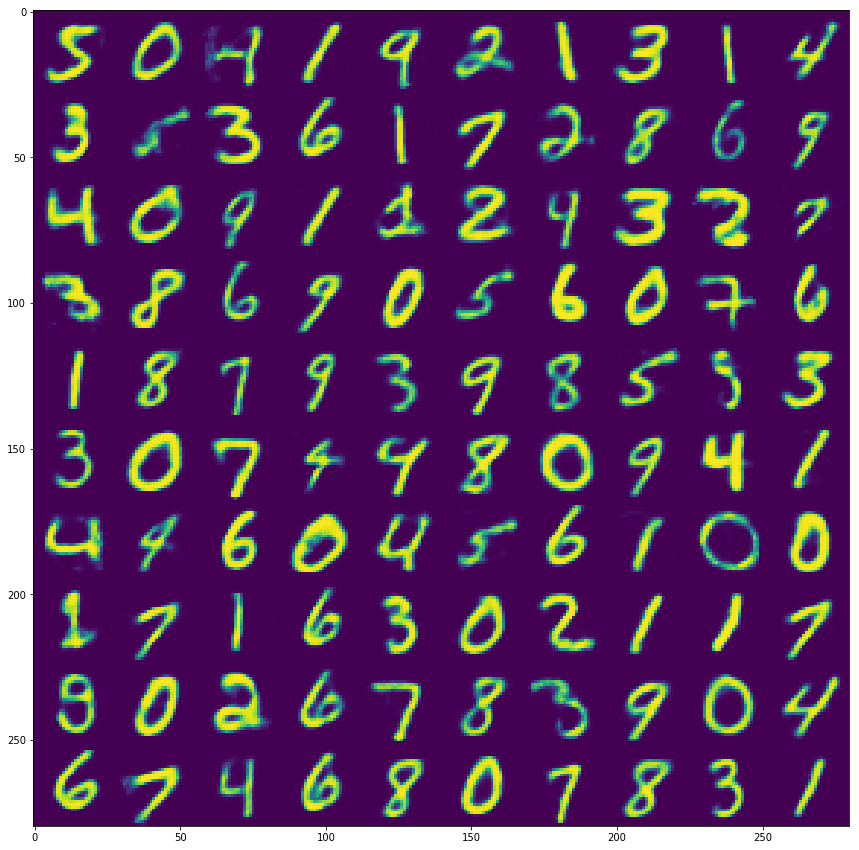

In [6]:
#reconstructed train images
imshow(sess.run(X_, feed_dict={X:x_train[:100]}))

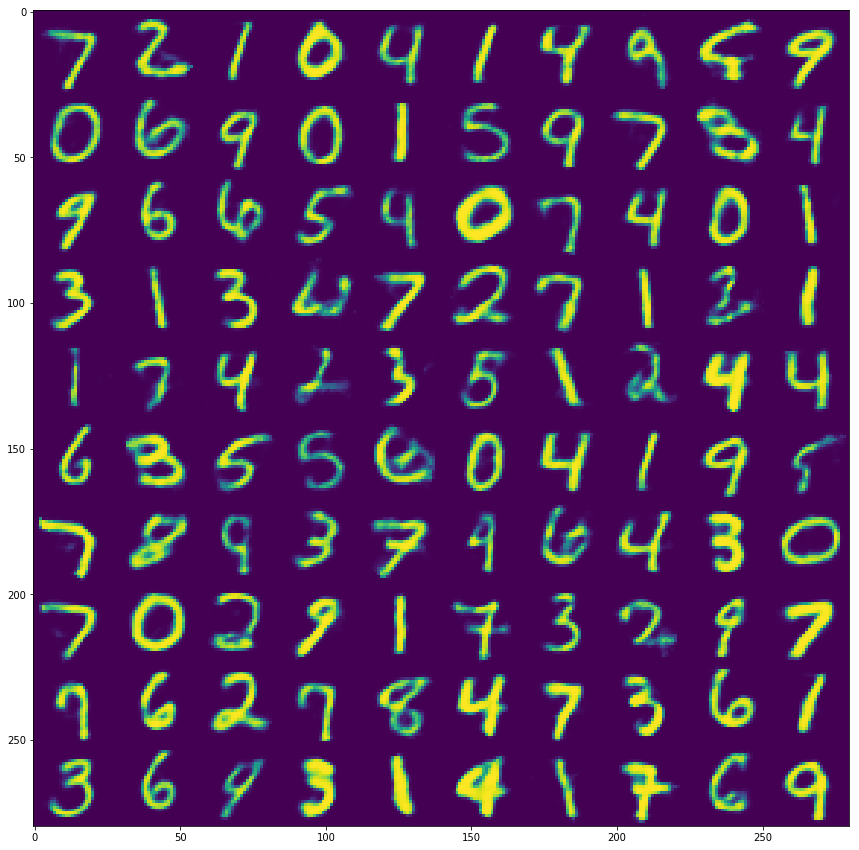

In [7]:
#reconstructed test images
imshow(sess.run(X_, feed_dict={X:x_test[:100]}))

In [8]:
cW1, cb1, cW2, cb2, cW3, cb3, cW4, cb4 = sess.run([W1, b1, W2, b2, W3, b3, W4, b4])

In [9]:
xdim2 = 280
xdim1 = xdim - xdim2

batch_size = 1
tf.reset_default_graph()
sess = tf.InteractiveSession()

X1 = tf.placeholder(tf.float32, shape=[batch_size, xdim1])
X2 = tf.get_variable('X2', initializer=tf.zeros([batch_size, xdim2]))
X = tf.concat([X1, X2], axis=1)
L = X
L = tf.matmul(L, cW1) + cb1
L = A(L)
L = tf.matmul(L, cW2) + cb2
L = A(L)
Z = L
L = tf.matmul(L, cW3) + cb3
L = A(L)
L = tf.matmul(L, cW4) + cb4
L = A(L)
X_ = L
    
LOSS_AUTO = tf.losses.mean_squared_error(X, X_)
LOSS_ZSPHERE = tf.reduce_mean(tf.square(tf.log(tf.reduce_sum(tf.square(Z), axis=1))))
LOSS = LOSS_AUTO + LOSS_ZSPHERE
TRAIN = tf.train.AdamOptimizer().minimize(LOSS)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Sample: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

Accuracy	AE: 90.56	RTAE: 96.22




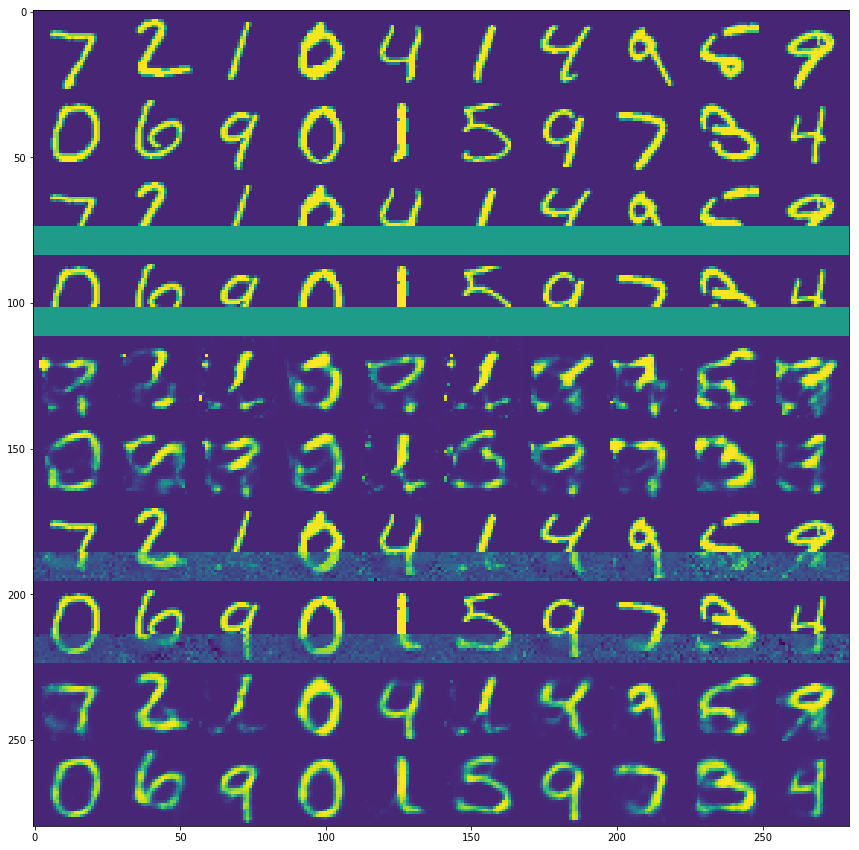

In [10]:
sample = 0

x    = np.zeros([0, xdim])
xin  = np.zeros([0, xdim])
xin_ = np.zeros([0, xdim])
xot  = np.zeros([0, xdim])
xot_ = np.zeros([0, xdim])

print('Sample:', end=' ')

for s in range(sample, sample + 20):
    print(s, end=', ')
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    x1 = x_test[s:s + 1, :xdim1]
    x    = np.vstack([x   , x_test[s:s + 1]])
    xin  = np.vstack([xin , sess.run(X , feed_dict={X1:x1})])
    xin_ = np.vstack([xin_, sess.run(X_, feed_dict={X1:x1})])
    for epoch in range(1000):
        sess.run(TRAIN, feed_dict={X1:x1})
    xot  = np.vstack([xot , sess.run(X , feed_dict={X1:x1})])
    xot_ = np.vstack([xot_, sess.run(X_, feed_dict={X1:x1})])
xim = np.vstack([x, xin, xin_, xot, xot_])
imshow(xim)
print("\n\nAccuracy\tAE: {:.2f}\tRTAE: {:.2f}\n\n".format((np.absolute(xin_ - x) < 1.).astype(float).mean() * 100.,(np.absolute(xot_ - x) < 1.).astype(float).mean() * 100.))